# **Install Packages**

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import Aer
from qiskit.opflow import CircuitSampler, PauliOp, MatrixEvolution, Suzuki
from qiskit.opflow import I, X, Y, Z, Zero, One, Plus, Minus, CX, CZ, Swap
from qiskit.circuit import Parameter
from qiskit import (
    QuantumCircuit,
    Aer,
    assemble,
    QuantumRegister,
    IBMQ,
    execute,
    transpile,
)
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import HamiltonianGate
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import random
from qiskit.tools.visualization import circuit_drawer
import warnings
import math

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (14, 7)

# **1 Qubit**

In [ ]:
def qubit_1(psi, g, delta_t, delta_x, V0, V1, n, N, color):
    gamma = 1 / (2 * delta_x**2)
    L = X
    U = (-1 * gamma * L * delta_t).exp_i()  # u.exp_i() returns e^(-iu)
    U = Operator(U)
    psi0_2, psi1_2 = psi[0] ** 2, psi[1] ** 2
    prob0 = [psi0_2]

    # step 1
    qc = QuantumCircuit(1)
    qc.initialize(psi, 0)
    qc.append(U, [0])

    # step 2
    qc.measure_all()

    # step 3
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    # print(counts)
    if "0" in counts:
        psi0_2 = counts["0"] / N
    else:
        psi0_2 = 0
    if "1" in counts:
        psi1_2 = counts["1"] / N
    else:
        psi1_2 = 0

    j = 0  # step 4
    V = []

    for j in range(n):  # step 5&10
        qc = QuantumCircuit(1)
        qc.initialize(psi, 0)

        # step 6

        V.append(
            Operator(
                [
                    [np.exp(((0 + 1j) * (g * psi0_2 - V0)) * delta_t), 0],
                    [0, np.exp(((0 + 1j) * (g * psi1_2 - V1)) * delta_t)],
                ]
            )
        )  # append V_j
        for i in range(j + 1):
            qc.append(U, [0])  # U
            qc.append(V[i], [0])  # V_i

        # measure ψ(j + 1)
        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(copy)
        if "0" in counts:
            psi0_2 = counts["0"] / N
            prob0.append(psi0_2)
        else:
            prob0.append(0)
        if "1" in counts:
            psi1_2 = counts["1"] / N

        # step 7
        qc.append(U, [0])

        # step 8
        qc.measure_all()

        # step 9
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(qc)
        # print(counts)
        if "0" in counts:
            psi0_2 = counts["0"] / N
        else:
            psi0_2 = 0
        if "1" in counts:
            psi1_2 = counts["1"] / N
        else:
            psi1_2 = 0
    plt.xlabel("n")
    plt.ylabel(r"$|\psi_0|^2$")
    title = r"$\Delta t$=" + str(delta_t)
    plt.title(title)
    plt.plot(prob0, color=color)
    # print(prob0)

In [ ]:
psi = [math.cos(math.pi / 6), math.sin(math.pi / 6)]
V0, V1 = 0, 0
qubit_1(psi, 1, 0.1, 1 / math.sqrt(2), V0, V1, 100, 1024, "red")
qubit_1(psi, 0, 0.1, 1 / math.sqrt(2), V0, V1, 100, 1024, "black")
qubit_1(psi, -1, 0.1, 1 / math.sqrt(2), V0, V1, 100, 1024, "blue")

In [ ]:
psi = [math.cos(math.pi / 4), math.sin(math.pi / 4)]
V0, V1 = -1, 0
qubit_1(psi, 1, 0.1, 1 / math.sqrt(2), V0, V1, 100, 1024 * 8, "red")
qubit_1(psi, 0, 0.1, 1 / math.sqrt(2), V0, V1, 100, 1024 * 8, "black")
qubit_1(psi, -1, 0.1, 1 / math.sqrt(2), V0, V1, 100, 1024 * 8, "blue")

# 2 Qubits

In [5]:
def get_prob(counts, N):
    keys = list(counts.keys())
    keys.sort()
    counts = {i: counts[i] for i in keys}
    for key in counts:
        counts[key] /= N
    counts = list(counts.items())
    # print(counts)
    prob = [0 for i in range(4)]
    for i in range(len(counts)):
        prob[int(counts[i][0], 2)] = counts[i][1]
    return prob


def qubit_2(psi, g, delta_t, delta_x, V_diag, n, N, color):
    gamma = 1 / (2 * delta_x**2)
    L = (((I + X)) ^ X) + (((-2 * I) ^ I))
    U = (-1 * gamma * L * delta_t).exp_i()  # u.exp_i() returns e^(-iu)
    U = Operator(U)
    data = []

    # step 1
    qc = QuantumCircuit(2)
    qc.initialize(psi, qc.qubits)
    qc.append(U, [0, 1])

    # step 2
    qc.measure_all()

    # step 3
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
    result_sim = job_sim.result()
    prob = get_prob(result_sim.get_counts(qc), N)
    # print(prob)

    j = 0  # step 4
    V = []

    for j in range(n):  # step 5&10
        qc = QuantumCircuit(2)
        qc.initialize(psi, [0, 1])

        # step 6
        Op = [[0 for k in range(4)] for i in range(4)]
        for i in range(4):
            Op[i][i] = np.exp((0 + 1j) * (g * prob[i] - V_diag[i]) * delta_t)
        V.append(Operator(Op))  # append V_j
        for i in range(j + 1):
            qc.append(U, [0, 1])  # U
            qc.append(V[i], [0, 1])  # V_i

        # measure ψ(j + 1)
        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(copy), N)
        data.append(prob)

        # step 7
        qc.append(U, [0, 1])

        # step 8
        qc.measure_all()

        # step 9
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(qc), N)

    """
  plt.xlabel('n')
  plt.ylabel(r'$|\psi_0|^2$')
  title = r'$\Delta t$=' + str(delta_t)
  plt.title(title)
  plt.plot(prob0,color=color)
  #print(prob0)
  """
    data = np.array(data).T
    for i in range(4):
        plt.plot(data[i])
    return

In [ ]:
psi = [1 / 2, 1 / 2, 1 / 2, 1 / 2]
V_diag = [1, 0, 0, 0]
qubit_2(psi, 1, 0.1, 1 / math.sqrt(2), V_diag, 100, 1024, "red")

# **Multiple Qubits (Cyclic)**



In [3]:
def get_prob(counts, N, numQubits):
    keys = list(counts.keys())
    keys.sort()
    counts = {i: counts[i] for i in keys}
    for key in counts:
        counts[key] /= N
    counts = list(counts.items())
    prob = [0 for i in range(2**numQubits)]
    # prob = np.zeros(2**numQubits) #[0 for i in range(2**numQubits)]
    for i in range(len(counts)):
        prob[int(counts[i][0], 2)] = counts[i][1]
    return prob


def L_diag(numQubits):
    if numQubits == 1:
        return -2 * I
    return L_diag(numQubits - 1) ^ I

In [4]:
def p(gate, size):
    data = Operator(gate).data
    for i in range(size):
        print(data[i].real)
    print("")


top_left = (I + Z) / 2
top_right = (X + (0 + 1j) * Y) / 2
bot_left = (X - (0 + 1j) * Y) / 2
bot_right = (I - Z) / 2


def EmptyGate(numQubits):
    gate = I - I
    for i in range(numQubits - 1):
        gate = gate ^ I
    return gate


def oneAt(i, j, numQubits):
    gate = EmptyGate(1)
    if i < 2**numQubits / 2 and j < 2**numQubits / 2:
        gate = top_left
    if i < 2**numQubits / 2 and j >= 2**numQubits / 2:
        gate = top_right
    if i >= 2**numQubits / 2 and j < 2**numQubits / 2:
        gate = bot_left
    if i >= 2**numQubits / 2 and j >= 2**numQubits / 2:
        gate = bot_right
    if numQubits == 1:
        return gate
    return gate ^ oneAt(
        i % (2**numQubits / 2), j % (2**numQubits / 2), numQubits - 1
    )


def L_cyclic(numQubits):
    gate = EmptyGate(numQubits)
    for i in range(2**numQubits):
        for j in range(2**numQubits):
            if (i, j) == (0, 2**numQubits - 1) or (j, i) == (0, 2**numQubits - 1):
                gate += oneAt(i, j, numQubits)
            if abs(i - j) == 1:
                gate += oneAt(i, j, numQubits)
    return L_diag(numQubits) + gate

In [34]:
def cyclic(numQubits, psi, g, delta_t, delta_x, V_diag, n, N, color):
    gamma = 1 / (2 * delta_x**2)
    L = L_cyclic(numQubits)
    U = (-1 * gamma * L * delta_t).exp_i()  # u.exp_i() returns e^(-iu)
    U = Operator(U)
    data = []
    # step 1
    qc = QuantumCircuit(numQubits)
    qc.initialize(psi, qc.qubits)
    qc.append(U, qc.qubits)

    # step 2
    qc.measure_all()

    # step 3
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
    result_sim = job_sim.result()
    prob = get_prob(result_sim.get_counts(qc), N, numQubits)

    j = 0  # step 4
    V = []

    for j in range(n):  # step 5&10
        qc = QuantumCircuit(numQubits)
        qc.initialize(psi, qc.qubits)

        # step 6
        Op = [[0 for k in range(2**numQubits)] for i in range(2**numQubits)]
        for i in range(2**numQubits):
            Op[i][i] = np.exp(
                (0 + 1j) * (g * prob[i] - V_diag[i]) * delta_t
            )  # e^(pi*i/2)
        print(Op)
        V.append(Operator(Op))  # append V_j
        for i in range(j + 1):
            qc.append(U, qc.qubits)  # U
            qc.append(V[i], qc.qubits)  # V_i

        # measure ψ(j + 1)
        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(copy), N, numQubits)
        data.append(prob)
        # print(prob)

        # step 7
        qc.append(U, qc.qubits)

        # step 8
        qc.measure_all()

        # step 9
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(qc, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(qc), N, numQubits)

    """
  plt.xlabel('n')
  plt.ylabel(r'$|\psi_0|^2$')
  title = r'$\Delta t$=' + str(delta_t)
  plt.title(title)
  plt.plot(prob0,color=color)
  #print(prob0)
  """
    data = np.array(data).T
    for i in range(2**numQubits):
        plt.figure(1)
        plt.plot(data[i])
    return data[0]

In [ ]:
psi = [1 / math.sqrt(16) for i in range(16)]
V_diag = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
data = cyclic(4, psi, 1, 0.1, 1 / math.sqrt(2), V_diag, 100, 1024 * 8, "red")
plt.figure(2)
plt.plot(data)

# Multiple Qubits (Complete Graph)

In [5]:
def L_complete(numQubits):
    gate = EmptyGate(numQubits)
    for i in range(2**numQubits):
        for j in range(2**numQubits):
            if i == j:
                gate -= (2**numQubits - 1) * oneAt(i, j, numQubits)
            else:
                gate += oneAt(i, j, numQubits)
    return gate

In [7]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit.providers.aer import AerSimulator
from scipy.linalg import expm


def complete(numQubits, psi, g, delta_t, delta_x, V_diag, n, N):
    gamma = 1 / (2 * delta_x**2)
    L = L_complete(numQubits)
    U = (-1 * gamma * L * delta_t).exp_i()  # u.exp_i() returns e^(-iu)
    U = Operator(U)

    data = np.zeros((n + 1, len(psi)))
    prob = np.square(psi)
    data[0] = prob  # [[psi[i]**2 for i in range(len(psi))]]

    # data = [[psi[i]**2 for i in range(len(psi))]]

    # step 1
    qc = QuantumCircuit(numQubits)
    qc.initialize(psi, qc.qubits)
    qc.append(U, qc.qubits)

    # step 4

    for j in range(n):  # step 5&
        # step 6
        V = [[0 for k in range(2**numQubits)] for i in range(2**numQubits)]
        for i in range(2**numQubits):
            V[i][i] = np.exp((0 + 1j) * (g * prob[i] - V_diag[i]) * delta_t)
        # V.append(Operator(Op)) #append V_j
        # qc.append(U,qc.qubits)
        qc.append(Operator(V), qc.qubits)

        # measure ψ(j + 1)
        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(copy), N, numQubits)
        data[j + 1] = prob  # data.append(prob) #
        # print(prob)

        # step 7
        qc.append(U, qc.qubits)

    return data.T


def complete_get_statevector(numQubits, psi, g, delta_t, delta_x, V_diag, n, N):
    gamma = 1 / (2 * delta_x**2)
    L = L_complete(numQubits)
    U = (-1 * gamma * L * delta_t).exp_i()
    U = Operator(U)

    data = np.zeros((n + 1, len(psi)))
    prob = np.square(psi)
    data[0] = prob

    statevector_list = [psi]

    for j in range(n):  # step 5&
        if j % 100 == 0:
            print(j)
        qc = QuantumCircuit(numQubits)
        qc.initialize(psi, qc.qubits)
        qc.append(U, qc.qubits)

        V = [[0 for k in range(2**numQubits)] for i in range(2**numQubits)]
        for i in range(2**numQubits):
            V[i][i] = np.exp((0 + 1j) * (g * prob[i] - V_diag[i]) * delta_t)
        qc.append(Operator(V), qc.qubits)

        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(copy), N, numQubits)
        data[j + 1] = prob

        statevector_circuit = copy.copy()  # This creates a new copy of the circuit
        statevector_circuit.remove_final_measurements()  # This removes the measurements from the copied circuit

        # 2. Use the statevector_simulator to get the statevector
        backend_statevector = Aer.get_backend("statevector_simulator")
        job_statevector = backend_statevector.run(
            transpile(statevector_circuit, backend_statevector)
        ).result()
        statevector = job_statevector.get_statevector()
        statevector_list.append(statevector)
        psi = statevector

    return np.array(statevector_list)


def complete_get_statevector_no_trotter(
    numQubits, psi, g, delta_t, delta_x, V_diag, n, N
):
    gamma = 1 / (2 * delta_x**2)
    # L = L_complete(numQubits)
    L = np.ones((8, 8), dtype=complex)
    np.fill_diagonal(L, -7 + 0j)

    data = np.zeros((n + 1, len(psi)))
    prob = np.square(psi)
    data[0] = prob

    statevector_list = [psi]

    for j in range(n):
        if j % 100 == 0:
            print(j)
        qc = QuantumCircuit(numQubits)
        qc.initialize(psi, qc.qubits)  # type: ignore

        H = -gamma * L + np.diag(V_diag) - np.diag(g * prob)

        gate = Operator(expm(-1j * H * delta_t)).to_instruction()
        qc.append(gate, qc.qubits)

        copy = qc.copy()
        copy.measure_all()
        backend_sim = Aer.get_backend("qasm_simulator")
        job_sim = backend_sim.run(transpile(copy, backend_sim), shots=N)
        result_sim = job_sim.result()
        prob = get_prob(result_sim.get_counts(copy), N, numQubits)
        data[j + 1] = prob

        statevector_circuit = copy.copy()  # This creates a new copy of the circuit
        statevector_circuit.remove_final_measurements()  # This removes the measurements from the copied circuit

        # 2. Use the statevector_simulator to get the statevector
        backend_statevector = Aer.get_backend("statevector_simulator")
        job_statevector = backend_statevector.run(
            transpile(statevector_circuit, backend_statevector)
        ).result()
        statevector = job_statevector.get_statevector()
        statevector_list.append(statevector)
        psi = statevector

    return np.array(statevector_list).T

def complete_get_statevector_no_trotter_no_meas(
    numQubits, psi, g, delta_t, delta_x, V_diag, n, N
):
    gamma = 1 / (2 * delta_x**2)
    # L = L_complete(numQubits)
    L = np.ones((8, 8), dtype=complex)
    np.fill_diagonal(L, -7 + 0j)

    prob = np.square(psi)

    statevector_list = [psi]

    for j in range(n):
        if j % 100 == 0:
            print(j)
        qc = QuantumCircuit(numQubits)
        qc.initialize(psi, qc.qubits)  # type: ignore

        H = -gamma * L + np.diag(V_diag) - np.diag(g * prob)

        gate = Operator(expm(-1j * H * delta_t)).to_instruction()
        qc.append(gate, qc.qubits)

        # 2. Use the statevector_simulator to get the statevector
        backend_statevector = Aer.get_backend("statevector_simulator")
        job_statevector = backend_statevector.run(
            transpile(qc, backend_statevector)
        ).result()
        statevector = job_statevector.get_statevector()
        statevector_list.append(statevector)
        prob = np.abs(statevector) ** 2
        psi = statevector

    return np.array(statevector_list).T

In [18]:
print(len(np.arange(0,40.01,0.02)))

2001


0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


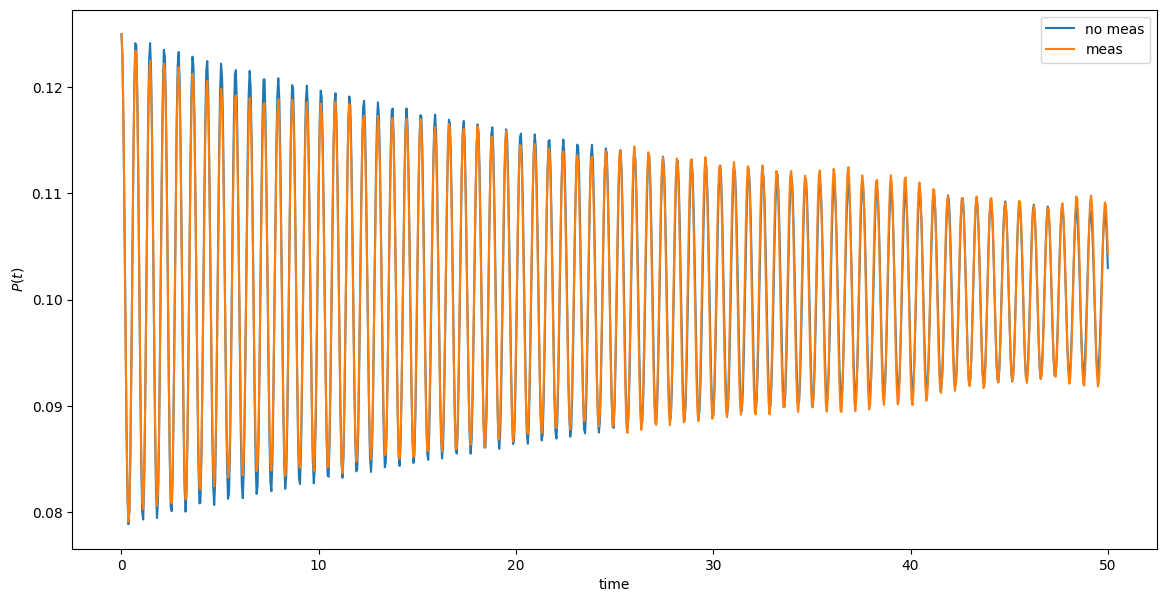

In [36]:
psi = np.array([1 / math.sqrt(8) for i in range(8)])
V_diag = np.array([1, 0, 0, 0, 0, 0, 0, 0])
data_005 = complete_get_statevector_no_trotter(3,psi,1,0.05,1/math.sqrt(2),V_diag,1000,512)
data_no_meas = complete_get_statevector_no_trotter_no_meas(3,psi,1,0.05,1/math.sqrt(2),V_diag,1000,1024)
# data_004 = complete_get_statevector_no_trotter_no_meas(3,psi,1,0.04,1/math.sqrt(2),V_diag,1000,1024*8)
# data_008 = complete_get_statevector_no_trotter_no_meas(3,psi,1,0.08,1/math.sqrt(2),V_diag,500,1024*8)

# data_002_trot = complete_get_statevector(3,psi,1,0.02,1/math.sqrt(2),V_diag,5000,1024*8)

# data_001 = complete_get_statevector_no_trotter(3,psi,1,0.01,1/math.sqrt(2),V_diag,10000,1024*8)

# data_001_trot = complete_get_statevector(3,psi,1,0.01,1/math.sqrt(2),V_diag,10000,1024*8)
# exact = np.load('exact.npy')
# exact_t = np.load('exact_t.npy')
# plt.plot(exact_t[:50000], exact[0][:50000])
plt.plot(np.arange(0, 50.01, 0.05), np.abs(data_no_meas[0]) ** 2)
plt.plot(np.arange(0, 50.01, 0.05), np.abs(data_005[0]) ** 2)

# plt.plot(np.arange(0, 40.01, 0.04), np.abs(data_004[0]) ** 2)
# plt.plot(np.arange(0,40.01, 0.08), np.abs(data_008[0]) ** 2)
plt.legend(['no meas','meas'])
plt.xlabel('time')
plt.ylabel(r'$P(t)$')
plt.show()
# plt.plot(np.abs(data_001_trot[:,0])**2)

# for i in range(8):

#     plt.plot(exc[i])
# for i in range(len(exc[0])):
#     print(np.sum(exc[:,i]))

# **Exact Solution (Complete Graph)**



In [8]:
from scipy.integrate import solve_ivp


def deriv(t, psi, gamma, numQubits, V, g):
    L = np.zeros(V.shape)
    for i in range(len(L)):
        for j in range(len(L)):
            L[i][j] = -(2**numQubits - 1) if i == j else 1
    K = np.diag(np.abs(psi) ** 2)
    psidot = np.matmul((-gamma * L + V - g * K) * (-1j), psi)
    psidot.tolist()
    return psidot


def exact_complete(numQubits, psi_init, gamma, V_diag, g, n, max_step):
    V = np.diag(V_diag)

    p = (gamma, numQubits, V, g)
    t0, tf = 0, n

    psi = tuple([complex(psi_init[i]) for i in range(len(psi_init))])
    soln = solve_ivp(deriv, (t0, tf), psi, args=p, max_step=max_step)

    for j in range(len(soln.y)):
        for i in range(len(soln.y[j])):
            soln.y[j][i] = np.absolute(soln.y[j][i]) ** 2  # |ψ|^2

    return soln.t, soln.y


def exact_complete_get_psi(numQubits, psi_init, gamma, V_diag, g, n, max_step):
    V = np.diag(V_diag)

    p = (gamma, numQubits, V, g)
    t0, tf = 0, n

    psi = tuple([complex(psi_init[i]) for i in range(len(psi_init))])
    soln = solve_ivp(deriv, (t0, tf), psi, args=p, max_step=max_step)

    return soln.t, soln.y

In [7]:
def compare(T, delta_t, N):
    psi = [1 / math.sqrt(8) for i in range(8)]
    V_diag = [1, 0, 0, 0, 0, 0, 0, 0]
    n = int(T / delta_t)
    data = np.zeros((N, n + 1))
    for i in range(N):
        print(str(i) + "/" + str(N))
        data[i] = (
            np.abs(
                complete_get_statevector_no_trotter(
                    3, psi, 1, delta_t, 1 / math.sqrt(2), V_diag, n, 1024 * 4
                )[0]
            )
            ** 2
        )
    mu_hat, stdev_hat = np.mean(data, axis=0), np.std(data, axis=0)
    # plt.plot(np.linspace(0,len(exact_data[1][0])-1,n+1),mu_hat)
    # plt.plot(exact_data[1][0])
    # plt.legend(['simulation','exact'])
    # plt.show()
    return mu_hat, stdev_hat

In [7]:
# psi = [1/math.sqrt(8) for i in range(8)]
# V_diag = [1,0,0,0,0,0,0,0]
# data = np.abs(exact_complete(3,psi,1,V_diag,1,50,0.001)[1][0])**2
# plt.plot(data)
from scipy.signal import find_peaks


def get_period(data):
    # Assuming 'data' is your np array
    peaks, _ = find_peaks(data)

    # Check for at least 2 peaks to compute a period
    return (peaks[-1] - peaks[0]) / (len(peaks) - 1)


def moving_avg(arr, window_size):
    num_values = len(arr) - window_size + 1

    # Create an empty array to store the moving average values
    avg = np.empty(num_values)

    # Compute the forward moving average
    for i in range(num_values):
        avg[i] = np.mean(arr[i : i + window_size])

    return avg

In [9]:
exact = np.load("exact.npy")
period_in_t = get_period(exact[0]) * 0.001
period_in_t

0.7228321167883212

In [ ]:
def fidelity(T, delta_t, max_N):
    psi = [1 / math.sqrt(8) for i in range(8)]
    V_diag = [1, 0, 0, 0, 0, 0, 0, 0]
    n = int(T / delta_t)
    exact_data = exact_complete_get_psi(3, psi, 1, V_diag, 1, T, max_step=delta_t)
    f = np.zeros(max_N)
    data = []
    for i in range(max_N):
        print(i)
        data.append(
            complete_get_statevector(
                3, psi, 1, delta_t, 1 / math.sqrt(2), V_diag, n, 1024 * 4
            )
        )
    f = np.zeros(max_N)
    avg = np.zeros((max_N, 8), dtype=complex)
    data = np.array(data)
    for i in range(1, max_N + 1):
        avg[i - 1][:] = np.mean(data[:i][:, -1], axis=0)
    for i in range(max_N):
        psi1 = avg[i]
        psi2 = exact_data[1][:, -1]
        f[i] = np.abs(np.dot(psi1.conj(), psi2)) ** 2
    return data, f


data, f = fidelity(T=50, delta_t=0.05, max_N=50)

# $L_1(t)=\frac{1}{N}\sum\limits_{i=1}^N|p_i(t)-\hat p(t)|$

# $L_2(t)=\frac{1}{N}\sqrt{\sum\limits_{i=1}^N|p(t)-\hat{p}(t)|^2}$

In [10]:
def f(T, delta_t, N):
    mu_hat, stdev_hat = compare(T, delta_t, N)
    err = np.zeros_like(mu_hat)
    exact_t = np.load("exact_t.npy")
    exact = np.load("exact.npy")
    exact_plot = []
    exact_plot_t = []
    for i in range(2, len(err)):
        t = round(i * delta_t, 3)
        exact_plot_t.append(t)
        err[i] = np.abs(exact[0][int(t / 0.001)] - mu_hat[i]) / (
            stdev_hat[i] / np.sqrt(N)
        )
        exact_plot.append(exact[0][int(t / 0.001)])
    # plt.plot(exact_plot_t,exact_plot)
    # plt.plot(exact_plot_t,mu_hat[2:])
    # plt.legend(['exact','muhat'])
    # plt.show()
    plt.plot(np.linspace(0, T, len(err))[2:], err[2:])
    plt.xlabel("time")
    plt.ylabel("f")
    plt.savefig("delta_t=" + str(round(delta_t, 3)) + ".png")
    plt.show()

    return err

In [ ]:
t_list = np.flip(np.arange(0.005, 0.1, 0.01))
for t in t_list:
    if True:
        err = f(T=50, delta_t=t, N=50)
        plt.plot(err)
        # avg = moving_avg(err,get_period(err))
        # plt.plot(,avg)
        np.save("N=50/f(T=50,delta_t=" + str(round(t, 3)) + ").npy", err)

f(T=500,delta_t=0.09).npy
f(T=500,delta_t=0.08).npy


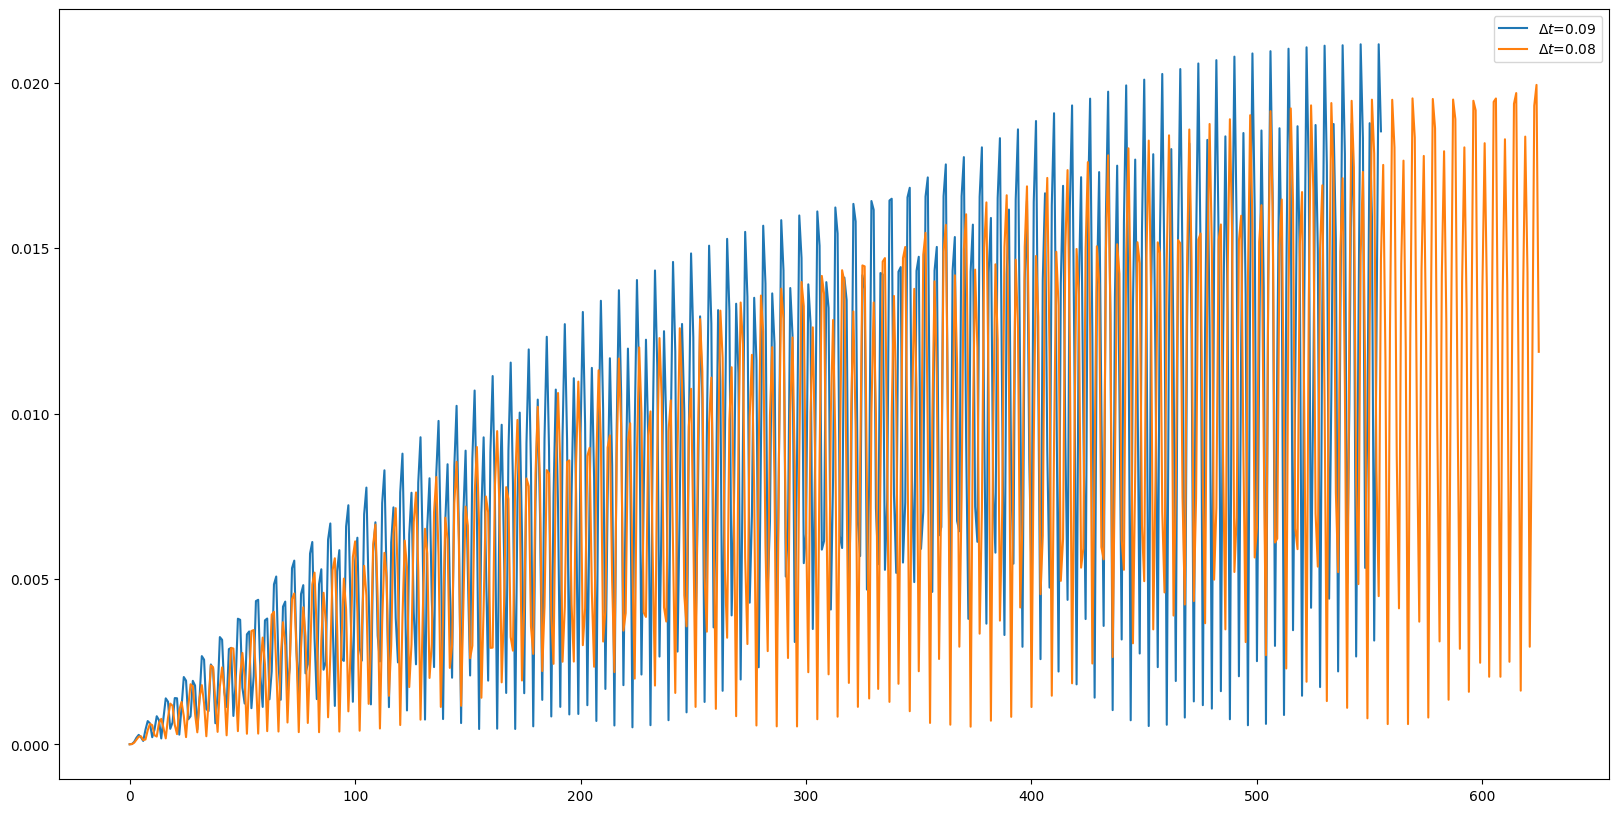

In [8]:
import os


def period_for_list(delta_t):
    return int(round(period_in_t / delta_t, 0))


data_avg = []
data_t_avg = []

folder_name = "M=4096"  # replace 'path_to_the_folder' with the actual path
directory = os.path.join(os.getcwd(), folder_name)
# directory.sort()

t_list = np.arange(0.01, 0.1, 0.005)
t_list = np.flip(t_list)
t_list = [0.09,0.08]
index = 0
lgd = []
count = 0

period = 0

x_y = []

# Iterate over all files in the directory
for filename in sorted(os.listdir(directory), reverse=True):
    if filename.endswith(".npy"):
        if "f" in filename:
            print(filename)
            if count >= 10:
                plt.legend(lgd)
                plt.show()
                count = 0
                lgd = []

            delta_t = round(t_list[index], 3)
            arr = np.load(os.path.join(directory, filename))
            plt.plot(arr)
            # plt.plot(np.arange(0,delta_t*len(arr),delta_t)[:1000],arr[:1000])
            # period = get_period(arr) * delta_t
            # print(period)
            # avg = moving_avg(arr, int(period / delta_t))
            # for i in range(3):
            #     avg = moving_avg(avg, int(get_period(avg)))
            # if delta_t == 0.095 or delta_t == 0.075:
            #     avg = moving_avg(avg, int(get_period(avg)))

            # x_val = np.arange(0, delta_t * len(avg), delta_t)
            # y_val = avg

            # max_len = min(len(x_val), len(y_val))
            # plt.plot(x_val[:max_len], y_val[:max_len])
            # xy = np.array([x_val[:max_len], y_val[:max_len]])
            # np.save("M=8192/" + str(delta_t) + ".npy", xy)
            # x_y.append((x_val[:max_len], y_val[:max_len]))
            index += 1
            lgd.append(r"$\Delta t$=" + str(delta_t))


plt.legend(lgd)
plt.show()

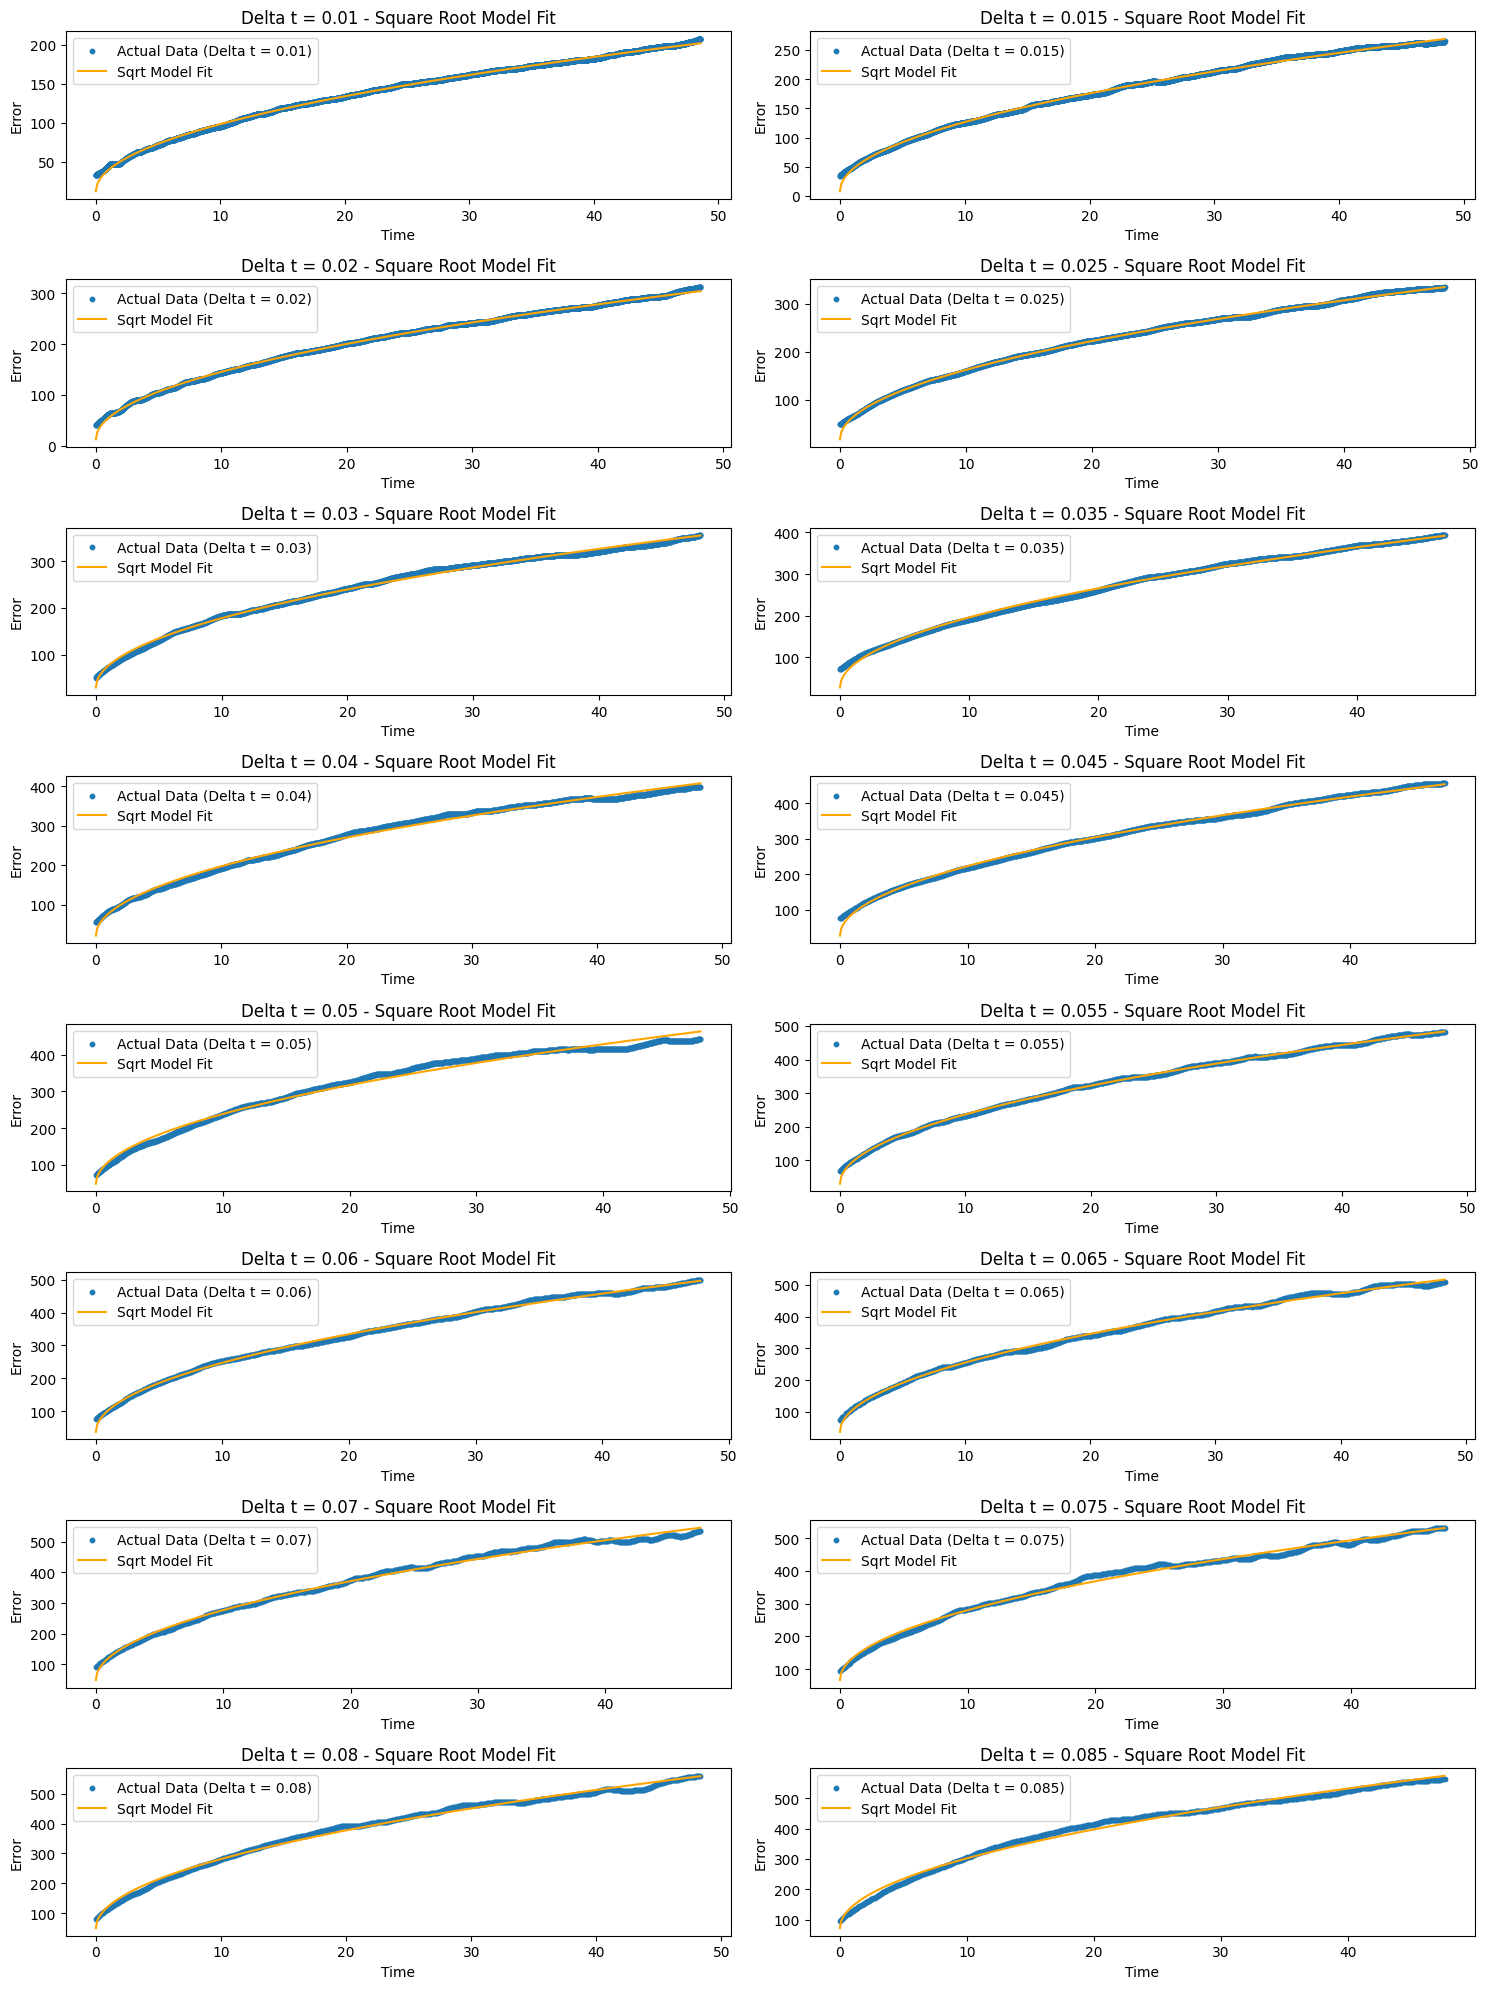

0.01: a=27.21865418328888, R2=0.9983150022295091, MSE=3.3762538104007542
0.015: a=37.50366996229376, R2=0.9979187029106288, MSE=7.903554800727393
0.02: a=42.11111844108566, R2=0.9985388135188638, MSE=6.9577197720745145
0.025: a=45.7442512312817, R2=0.9987479474351143, MSE=7.003024934988626
0.03: a=46.896424159836315, R2=0.996676714434123, MSE=19.642201260219814
0.035: a=53.16500172471795, R2=0.9965398569388372, MSE=25.592822046570355
0.04: a=55.670106799039324, R2=0.9938480184751617, MSE=51.58956738454681
0.045: a=61.921727499629235, R2=0.9971201995581805, MSE=29.266915462527237
0.05: a=60.053490677030624, R2=0.9868355629567847, MSE=127.91282052155373
0.055: a=65.32755067833543, R2=0.9988486350307791, MSE=13.22997156033426
0.06: a=66.53821853322307, R2=0.9977887018512831, MSE=26.17049186697004
0.065: a=69.04625356683677, R2=0.997300734724737, MSE=34.81473125064444
0.07: a=72.02588641802002, R2=0.9943321042832881, MSE=78.45021636250935
0.075: a=67.41241895579458, R2=0.9934328104799905, 

<Figure size 2000x1000 with 0 Axes>

In [76]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error


# Define the square root model function
def sqrt_model(x, a, b):
    return a * np.sqrt(x) + b


# List of delta_t values
delta_ts = np.arange(0.01, 0.09, 0.005)

# Load the data from .npy files and store in a dictionary with delta_t as keys
data_dict = {}
for delta_t in delta_ts:
    delta_t = round(delta_t, 4)
    file_path = f"M=8192/{delta_t}.npy"
    data = np.load(file_path, allow_pickle=True)
    data_dict[delta_t] = {"x_coordinates": data[0], "y_coordinates": data[1]}

# Fit the square root model to each dataset and calculate the performance metrics
sqrt_model_fits = {}
for delta_t, data in data_dict.items():
    # Fit the square root model
    sqrt_params, _ = curve_fit(sqrt_model, data["x_coordinates"], data["y_coordinates"])

    # Calculate performance
    y_pred = sqrt_model(data["x_coordinates"], *sqrt_params)
    r2 = r2_score(data["y_coordinates"], y_pred)
    mse = mean_squared_error(data["y_coordinates"], y_pred)

    # Store the results
    sqrt_model_fits[delta_t] = {
        "sqrt_params": sqrt_params,
        "performance": {"R2": r2, "MSE": mse},
    }

# Plotting the actual data and the fitted models for each delta_t
plt.figure(figsize=(15, 20))
for i, (delta_t, data) in enumerate(data_dict.items()):
    # Generate a range of x values for plotting the fitted model
    x_range = np.linspace(min(data["x_coordinates"]), max(data["x_coordinates"]), 500)
    # Generate the predicted y values using the fitted square root model
    y_pred = sqrt_model(x_range, *sqrt_model_fits[delta_t]["sqrt_params"])

    # Subplot for each delta_t
    plt.subplot(len(data_dict) // 2 + len(data_dict) % 2, 2, i + 1)
    plt.scatter(
        data["x_coordinates"],
        data["y_coordinates"],
        s=10,
        label=f"Actual Data (Delta t = {delta_t})",
    )
    plt.plot(x_range, y_pred, color="orange", label="Sqrt Model Fit")
    plt.title(f"Delta t = {delta_t} - Square Root Model Fit")
    plt.xlabel("Time")
    plt.ylabel("Error")
    plt.legend()

plt.tight_layout()
plt.show()
plt.savefig("data_fit.png")

a_8192 = {}
for delta_t in sqrt_model_fits.keys():
    print(
        f'{delta_t}: a={sqrt_model_fits[delta_t]["sqrt_params"][0]}, R2={sqrt_model_fits[delta_t]["performance"]["R2"]}, MSE={sqrt_model_fits[delta_t]["performance"]["MSE"]}'
    )
    a_8192[delta_t] = sqrt_model_fits[delta_t]["sqrt_params"][0]

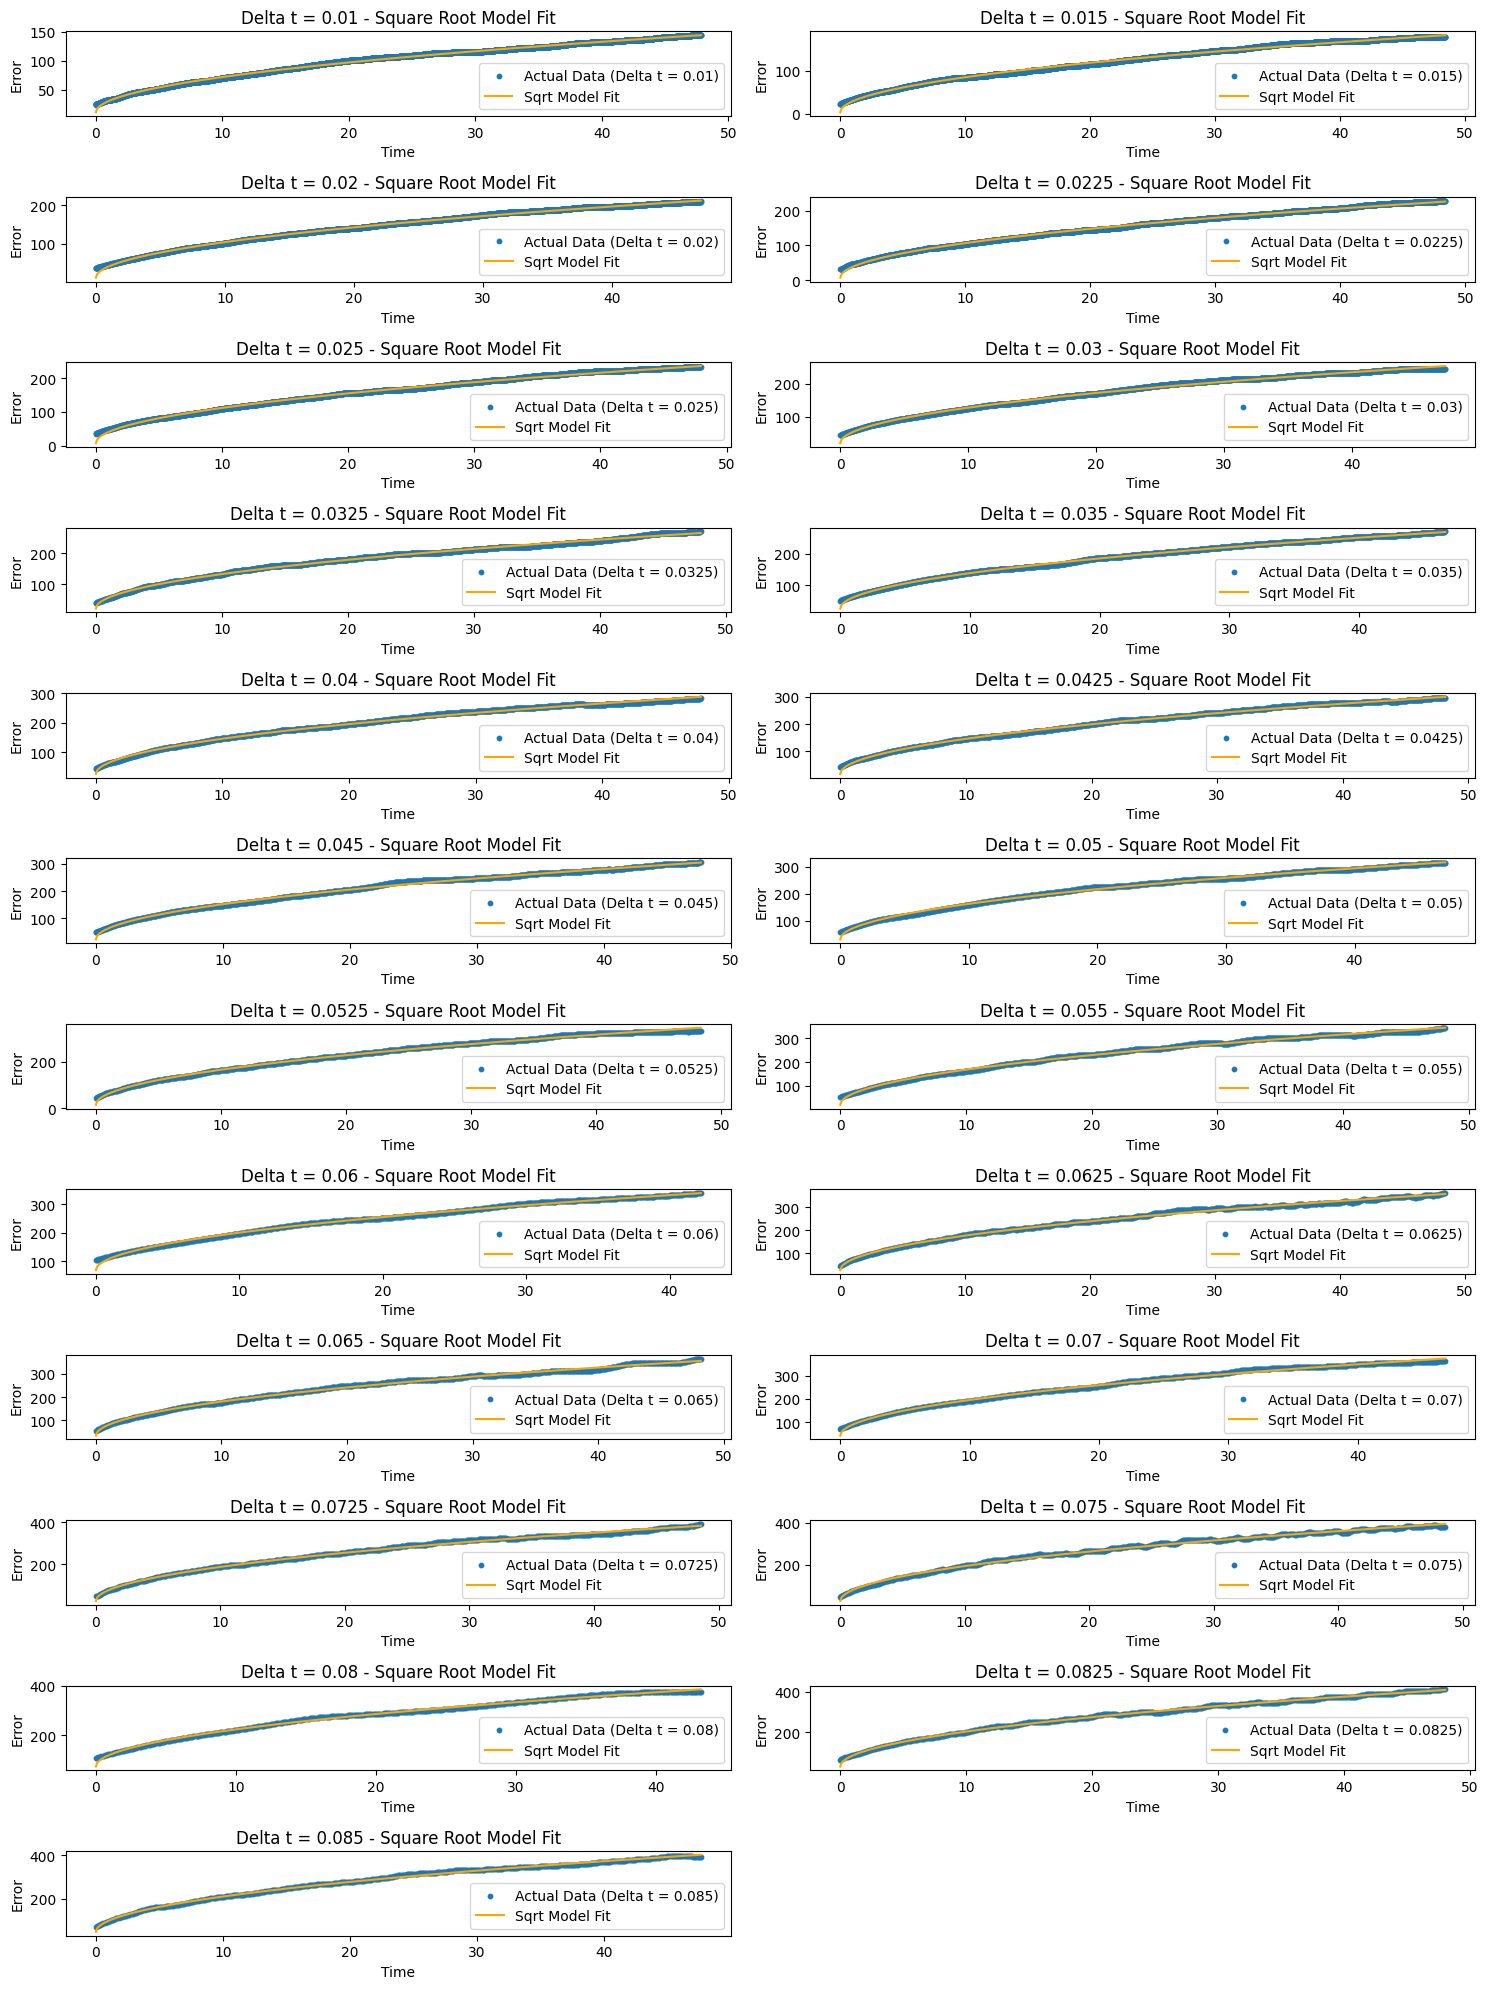

0.01: a=19.30567725598203, R2=0.9969001979105875, MSE=3.080833635507674
0.015: a=25.549670080051023, R2=0.9952635996971093, MSE=8.369834885201806
0.02: a=29.138651806610607, R2=0.9973892806412995, MSE=5.800875079635237
0.0225: a=31.373365437436778, R2=0.996664644417849, MSE=8.873475276300175
0.025: a=33.015100234700895, R2=0.9958712693762597, MSE=12.063811728191828
0.03: a=34.168585183532265, R2=0.9960224576385518, MSE=12.278323433248458
0.0325: a=34.883416856831026, R2=0.9965238105326242, MSE=11.359252718806617
0.035: a=35.64799375735231, R2=0.9981721983299654, MSE=6.050116522068297
0.04: a=37.65947573474311, R2=0.9965541490933065, MSE=13.067765940777797
0.0425: a=40.860817551980794, R2=0.9971472472307634, MSE=12.824797905230936
0.045: a=40.48644207161652, R2=0.9963758161720648, MSE=15.846741702824843
0.05: a=41.59204559571588, R2=0.9967732528932076, MSE=14.70247268069585
0.0525: a=47.96779435608024, R2=0.9964717902721179, MSE=21.983239508491238
0.055: a=46.94477502126882, R2=0.995928

<Figure size 2000x1000 with 0 Axes>

In [81]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error


# Define the square root model function
def sqrt_model(x, a, b):
    return a * np.sqrt(x) + b


# List of delta_t values
delta_ts = np.arange(0.01, 0.09, 0.005)
delta_ts = np.append(delta_ts, np.arange(0.0225, 0.09, 0.01))
delta_ts = np.sort(delta_ts)

# Load the data from .npy files and store in a dictionary with delta_t as keys
data_dict = {}
for delta_t in delta_ts:
    delta_t = round(delta_t, 4)
    file_path = f"N=500/{delta_t}.npy"
    data = np.load(file_path, allow_pickle=True)
    data_dict[delta_t] = {"x_coordinates": data[0], "y_coordinates": data[1]}

# Fit the square root model to each dataset and calculate the performance metrics
sqrt_model_fits = {}
for delta_t, data in data_dict.items():
    # Fit the square root model
    sqrt_params, _ = curve_fit(sqrt_model, data["x_coordinates"], data["y_coordinates"])

    # Calculate performance
    y_pred = sqrt_model(data["x_coordinates"], *sqrt_params)
    r2 = r2_score(data["y_coordinates"], y_pred)
    mse = mean_squared_error(data["y_coordinates"], y_pred)

    # Store the results
    sqrt_model_fits[delta_t] = {
        "sqrt_params": sqrt_params,
        "performance": {"R2": r2, "MSE": mse},
    }

# Plotting the actual data and the fitted models for each delta_t
plt.figure(figsize=(15, 20))
for i, (delta_t, data) in enumerate(data_dict.items()):
    # Generate a range of x values for plotting the fitted model
    x_range = np.linspace(min(data["x_coordinates"]), max(data["x_coordinates"]), 500)
    # Generate the predicted y values using the fitted square root model
    y_pred = sqrt_model(x_range, *sqrt_model_fits[delta_t]["sqrt_params"])

    # Subplot for each delta_t
    plt.subplot(len(data_dict) // 2 + len(data_dict) % 2, 2, i + 1)
    plt.scatter(
        data["x_coordinates"],
        data["y_coordinates"],
        s=10,
        label=f"Actual Data (Delta t = {delta_t})",
    )
    plt.plot(x_range, y_pred, color="orange", label="Sqrt Model Fit")
    plt.title(f"Delta t = {delta_t} - Square Root Model Fit")
    plt.xlabel("Time")
    plt.ylabel("Error")
    plt.legend()

plt.tight_layout()
plt.show()
plt.savefig("data_fit.png")

a_4096 = {}
for delta_t in sqrt_model_fits.keys():
    print(
        f'{delta_t}: a={sqrt_model_fits[delta_t]["sqrt_params"][0]}, R2={sqrt_model_fits[delta_t]["performance"]["R2"]}, MSE={sqrt_model_fits[delta_t]["performance"]["MSE"]}'
    )
    a_4096[delta_t] = sqrt_model_fits[delta_t]["sqrt_params"][0]

In [48]:
a = {}
a[0.01] = 19.30567725598203
a[0.015] = 25.549670080051023
a[0.02] = 29.138651806610607
a[0.0225] = 31.373365437436778
a[0.025] = 33.015100234700895
a[0.03] = 34.168585183532265
a[0.0325] = 34.883416856831026
a[0.035] = 35.64799375735231
a[0.04] = 37.65947573474311
a[0.0425] = 40.860817551980794
a[0.045] = 40.48644207161652
a[0.05] = 41.59204559571588
a[0.0525] = 47.96779435608024
a[0.055] = 46.80747992743985
a[0.06] = 41.85674507163787
a[0.0625] = 48.04846787182125
a[0.065] = 45.97405222009227
a[0.07] = 48.49606113473303
a[0.0725] = 51.217913434374076
a[0.075] = 51.80052330978681
a[0.08] = 47.76491957786931
a[0.0825] = 54.242342989489984
a[0.085] = 51.745723658933194
a[0.09] = 51.69434934563334
a[0.095] = 54.5289566891487


# a[0.055] =46.94477502126882
# a[0.07] =48.49606113473303

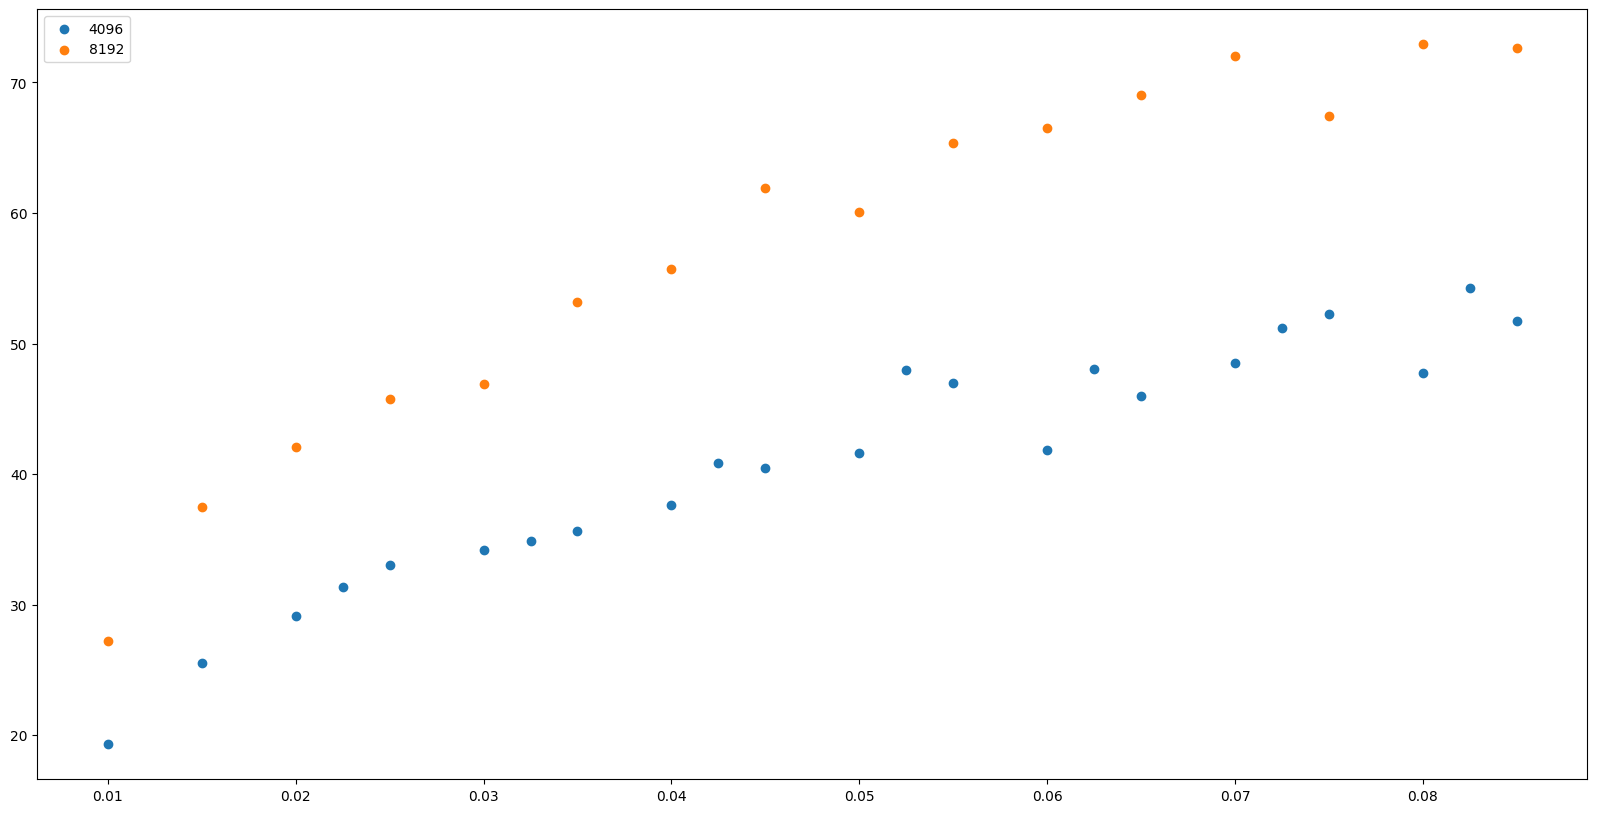

In [82]:
# plt.plot(sorted(a.keys()),sorted(a.values()))

plt.scatter(a_4096.keys(), a_4096.values())
plt.scatter(a_8192.keys(), a_8192.values())
plt.legend(["4096", "8192"])

dict_keys([0.01, 0.015, 0.02, 0.0225, 0.025, 0.03, 0.0325, 0.035, 0.04, 0.0425, 0.045, 0.05, 0.0525, 0.055, 0.06, 0.0625, 0.065, 0.07, 0.0725, 0.075, 0.08, 0.0825, 0.085])
0.9451037221328408
0.9563631755607741


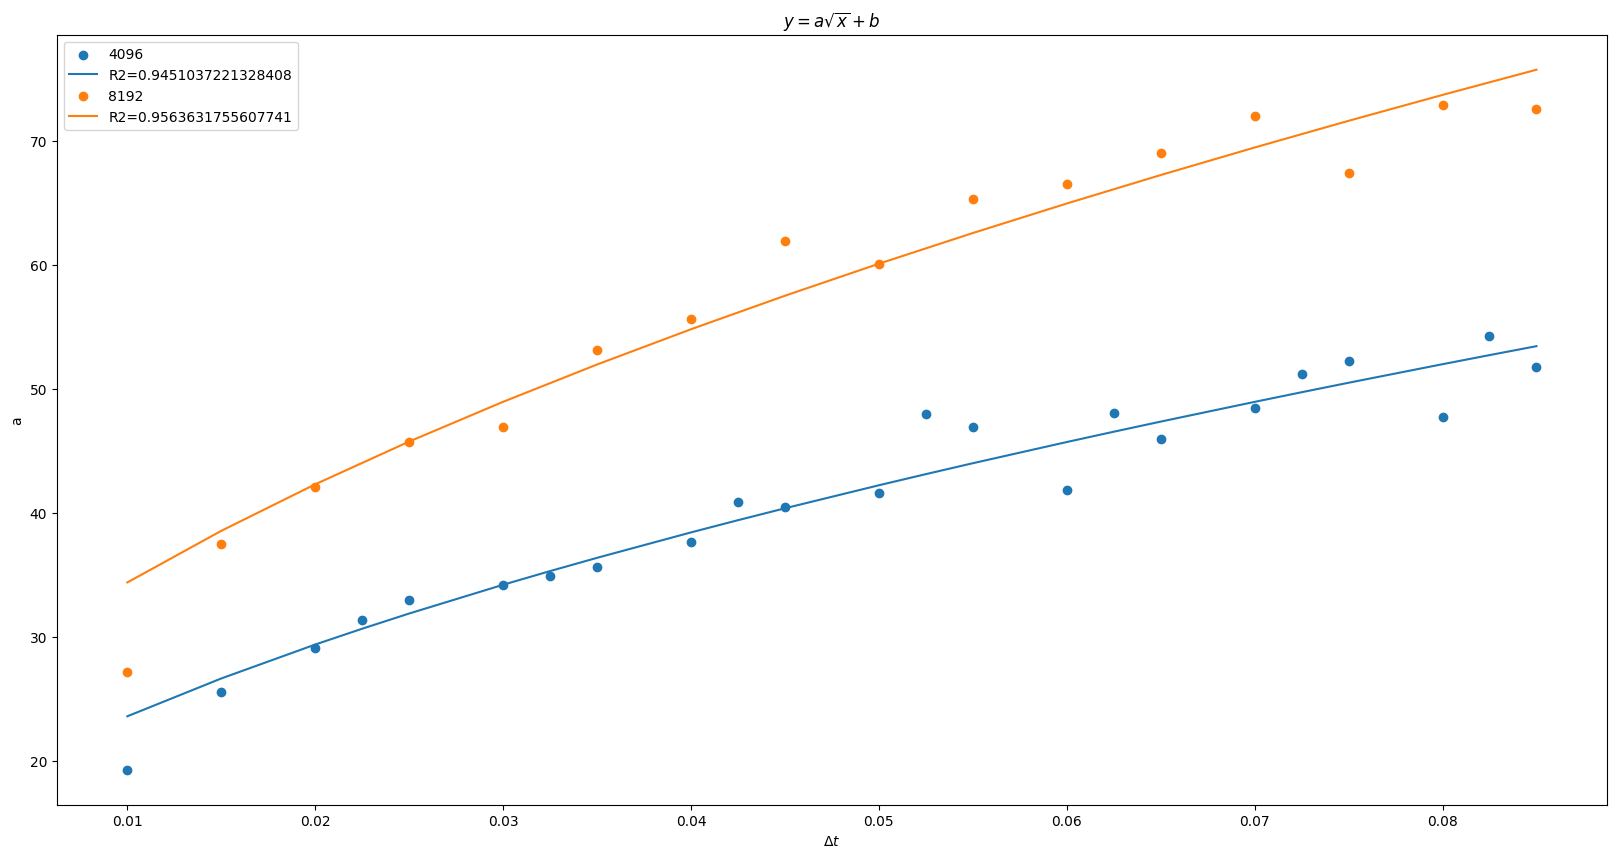

In [83]:
def fit_square_root(x, y, M):
    """
    Fits a square root function to the given data and evaluates its goodness of fit.

    Parameters:
    - x (list): List of x-values.
    - y (list): List of y-values.

    Returns:
    - float: R-squared value for the square root fit.
    """

    x = np.array(x)
    y = np.array(y)

    # Square the y-values to linearize the relationship
    y_squared = np.square(y)

    # Fit a linear model to the transformed data
    coefficients = np.polyfit(x, y_squared, 1)
    p = np.poly1d(coefficients)

    # Calculate the fitted y-values using the square root function
    y_fit = np.sqrt(p(x))

    # Calculate R-squared value for the fit
    residuals = y - y_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Plot original data and fitted curve
    plt.scatter(x, y, label=str(M))
    plt.plot(x, y_fit, label=f"R2={r_squared}")
    plt.xlabel(r"$\Delta t$")
    plt.ylabel("a")
    plt.title(r"$y=a\sqrt{x}+b$")

    return r_squared


print(a_4096.keys())
r_square_4096 = fit_square_root(list(a_4096.keys()), list(a_4096.values()), 4096)
print(r_square_4096)
r_square_8192 = fit_square_root(list(a_8192.keys()), list(a_8192.values()), 8192)
print(r_square_8192)
plt.legend()
plt.savefig("sqrt_fit.png")
plt.show()


# Example usage
# for i in range(len(data_t_avg)):
#     x_values = data_t_avg[i]
#     y_values = data_avg[i]
#     r2 = fit_square_root(x_values, y_values)
#     print(f"R-squared value for square root fit: {r2:.4f}")